# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [28]:
import copy
import os

import kagglehub
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Baseline para clasificador
Para el baseline del proyecto se seleccionó una arquitectura ResNet18. La selección fue motivada por las siguientes características: 
- Es ligero y se entrena rápidamente.
- Tiene un buen rendimiento en conjuntos de datos pequeños y medianos.
- Está disponible directamente a través de torchvision.models.
- Admite aprendizaje por transferencia.

### Carga y preprocesamiento del dataset

Carga y preprocesamiento del dataset TrashNet. Más información sobre el EDA del dataset en [02-trashnet-baseline.ipynb](./02-trashnet-baseline.ipynb)

In [22]:
dataset_path = kagglehub.dataset_download("feyzazkefe/trashnet")
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "dataset-resized")

full_dataset = datasets.ImageFolder(root=dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Path to dataset files: /home/ggf/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Definición de transformaciones a aplicar en etapa de preprocesamiento.

In [23]:
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

1. División del dataset en datos para entrenamiento y datos de validación.
2. Aplicación de transformaciones definidas previamente.
3. Creación de data loaders.

In [24]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

### Definición del modelo baseline
A continuación se carga el modelo pre-entrenado ResNet18 y se congelan las capas previas:

In [25]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

/home/ggf/workspace/ceia/ceia-vpc2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ggf/workspace/ceia/ceia-vpc2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Entrenamiento y validación del modelo baseline

Definición del esquema de entrenamiento y validación.

In [26]:
def train_validate(
    model, train_loader, val_loader, criterion, optimizer, device, epochs=10
):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        preds, targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(targets, preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if val_acc > best_acc: # save the best model
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Best accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

Ejecución del entrenamiento y validación:

In [27]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_validate(
    model, train_loader, val_loader, criterion, optimizer, device, epochs=10
)

Epoch 1/10 | Train Loss: 0.0448, Train Acc: 0.4755 | Val Loss: 1.1597, Val Acc: 0.5613
Epoch 2/10 | Train Loss: 0.0322, Train Acc: 0.6428 | Val Loss: 0.8748, Val Acc: 0.7055
Epoch 3/10 | Train Loss: 0.0261, Train Acc: 0.7284 | Val Loss: 0.7465, Val Acc: 0.7609
Epoch 4/10 | Train Loss: 0.0231, Train Acc: 0.7674 | Val Loss: 0.6900, Val Acc: 0.7411
Epoch 5/10 | Train Loss: 0.0209, Train Acc: 0.7912 | Val Loss: 0.6519, Val Acc: 0.7569
Epoch 6/10 | Train Loss: 0.0200, Train Acc: 0.7986 | Val Loss: 0.6286, Val Acc: 0.7964
Epoch 7/10 | Train Loss: 0.0187, Train Acc: 0.8194 | Val Loss: 0.5743, Val Acc: 0.8043
Epoch 8/10 | Train Loss: 0.0174, Train Acc: 0.8238 | Val Loss: 0.5490, Val Acc: 0.8202
Epoch 9/10 | Train Loss: 0.0169, Train Acc: 0.8229 | Val Loss: 0.5316, Val Acc: 0.8241
Epoch 10/10 | Train Loss: 0.0168, Train Acc: 0.8347 | Val Loss: 0.5142, Val Acc: 0.8261
Best accuracy: 0.8261


Visualización de resultados:

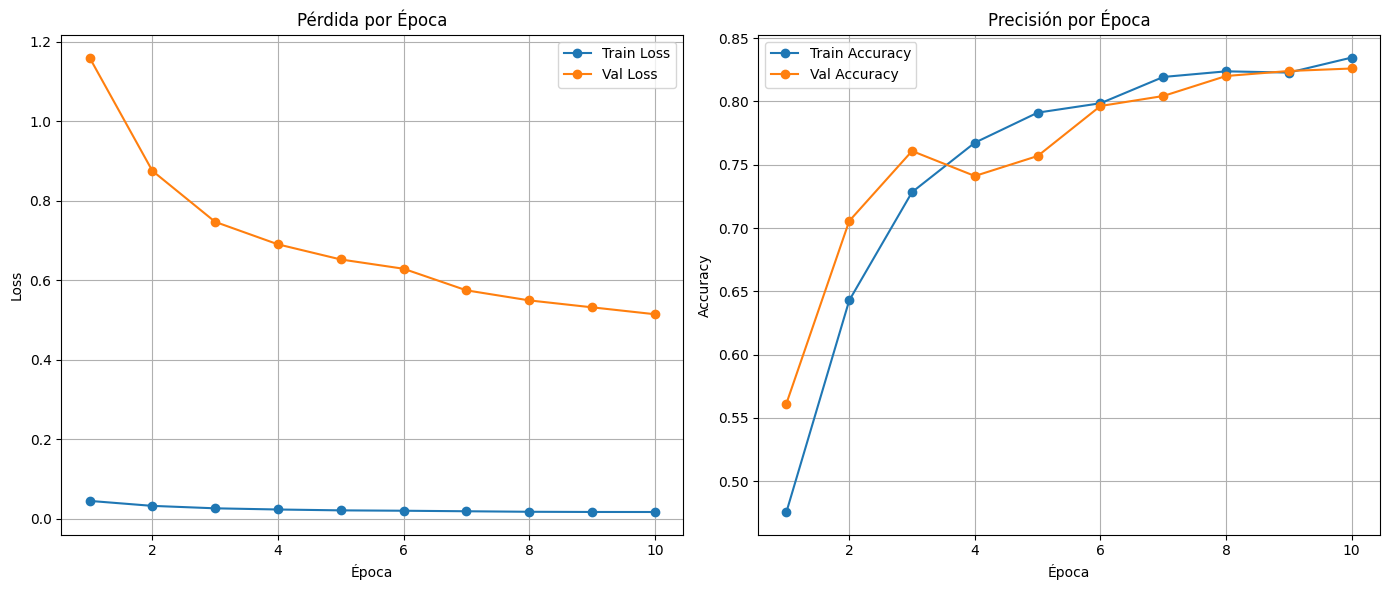

In [29]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_range, val_losses, label="Val Loss", marker="o")
plt.title("Pérdida por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy", marker="o")
plt.title("Precisión por Época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Exportación del modelo entrenado.

In [ ]:
torch.save(model.state_dict(), "output/trashnet_baseline_model.pth")